In [1]:
import os, json
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

# 1. Analyze raw data

In [2]:
TRAIN_DIR  = '/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData'
VAL_DIR    = '/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation'
MODALITIES = ['t1c', 't1n', 't2f', 't2w']

## Helper functions

In [3]:
def save_json(path, data):
    with open(path, 'w') as json_file:
        json.dump(data, json_file, indent=4)

def load_json(path):
    data = None
    with open(path, 'r') as json_file:
        data = json.load(json_file)
    return data

def get_file_dict(base_dir):
    file_dict = {}

    for subdir, _, filenames in os.walk(base_dir):
        if subdir == base_dir:
            continue  # Skip the base directory itself

        id_ = os.path.relpath(subdir, base_dir)
        filepaths = [os.path.join(base_dir, id_, filename) for filename in filenames]
        file_dict[id_] = filepaths

    return file_dict

def get_filepaths(file_dict, id_, modatily='all'):
    if modatily == 'all':
        return file_dict.get(id_)
    else:
        result = []
        filepaths = file_dict.get(id_)
        for filepath in filepaths:
            if modatily in filepath:
                result.append(filepath)
        return result

def get_image_paths_by_id(id_, base_dir):
    paths = []
    for mod in MODALITIES:
        path = os.path.join(base_dir, id_, f'{id_}-{mod}.nii.gz')
        paths.append(path)
    return paths

def get_mask_path_by_id(id_, base_dir):
    return os.path.join(base_dir, id_, f'{id_}-seg.nii.gz')

## Get training and validation file dictionaries

In [4]:
# train_file_dict = get_file_dict(TRAIN_DIR)
# val_file_dict   = get_file_dict(VAL_DIR)

train_file_dict = load_json('train_file_dict.json')
val_file_dict = load_json('val_file_dict.json')

train_ids = list(train_file_dict.keys())
val_ids   = list(val_file_dict.keys())

In [5]:
train_ids_tps = [id_.split('-')[-1] for id_ in train_ids]
np.unique(train_ids_tps)

array(['000', '001', '002', '003', '004', '005', '006'], dtype='<U3')

In [6]:
val_ids_tps = [id_.split('-')[-1] for id_ in val_ids]
np.unique(val_ids_tps)

array(['000'], dtype='<U3')

## Check missing modalities

In [56]:
def validate_files(file_dict, modalities):
    missing_modatily_ids = []

    for id_, filenames in file_dict.items():
        extracted_modalities = [filename.split('-')[-1].split('.')[0] for filename in filenames]
        all_modalities_present = all(modality in extracted_modalities for modality in modalities)
        if not all_modalities_present: missing_modatily_ids.append(id_)

    if len(missing_modatily_ids) > 0:
        print(f'Missing modalities in these ids: {missing_modatily_ids}')
        return False

    return True

In [57]:
# Check training files & save filenames by ids to a JSON file
train_modalities = MODALITIES + ['seg']
is_train_files_ok = validate_files(train_file_dict, train_modalities)
# if is_train_files_ok:
#     save_json('train_file_dict.json', train_file_dict)

# Check validation files  & save filenames by ids to a JSON file
is_val_files_ok = validate_files(train_file_dict, MODALITIES)
# if is_val_files_ok:
#     save_json('val_file_dict.json', val_file_dict)

## Check number of files

In [58]:
n_train_ids = len(train_ids)
n_train_files = np.sum([len(paths) for paths in train_file_dict.values()])

n_val_ids = len(val_ids)
n_val_files = np.sum([len(paths) for paths in val_file_dict.values()])

print(f'Training data: {n_train_ids} ids, {n_train_files} files.')
print(f'Validation data: {n_val_ids} ids, {n_val_files} files.')

Training data: 652 ids, 3260 files.
Validation data: 88 ids, 352 files.


## Check shape, orientation, and spacing of files

In [15]:
def get_nifti_details_for_one_file(filepath):
    # Load image object
    img = nib.load(filepath)
    header = img.header

    # Shape
    shape = header.get_data_shape()

    # Spacing
    spacing = header.get_zooms()

    # Orientation
    orientation = nib.orientations.aff2axcodes(img.affine)

    # Affine
    affine = img.affine.copy()

    # Intensity
    try:
        image_data = img.get_fdata()
    except:
        print(f'Error when run .get_dfata() for this image using Nibabel: {filepath}')
        print('Using SimpleITK')
        img = sitk.ReadImage(filepath)
        image_data = sitk.GetArrayFromImage(img)
    
    intensity = (image_data.min(), image_data.max())

    return {
        'filepath'   : filepath,
        'shape'      : shape,
        'orientation': orientation,
        'spacing'    : spacing,
        'affine'     : affine,
        'intensity'  : intensity
    }

def get_nifti_details(file_dict):
    nifti_details_list = []

    for paths in file_dict.values():
        for path in paths:
            nifti_details_list.append(get_nifti_details_for_one_file(path))
    
    return nifti_details_list

In [61]:
train_nifti_details = get_nifti_details(train_file_dict)
df = pd.DataFrame(train_nifti_details)
df.to_json('train_nifti_details.json', orient='records')
df.head()

# df = pd.read_json('train_nifti_details.json')
# df.head()

Error when run .get_dfata() for this image using Nibabel: /media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00232-000/BraTS-MET-00232-000-t2w.nii.gz
Using SimpleITK
Error when run .get_dfata() for this image using Nibabel: /media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00584-000/BraTS-MET-00584-000-t1n.nii.gz
Using SimpleITK


In [60]:
# Save value counts for each column except filepath
def save_value_counts(df, phase='train'):
    cols_of_interest = [
        'shape', 'orientation', 'spacing', 'intensity'
    ]

    for col in cols_of_interest:
        df_tosave = df[col].value_counts()
        df_tosave = df_tosave.reset_index()

        with open(f'{phase}_{col}.txt', 'w') as f:
            f.write(df_tosave.to_string(index=False))

save_value_counts(df)

NameError: name 'df' is not defined

In [17]:
val_nifti_details = get_nifti_details(val_file_dict)
dfv = pd.DataFrame(val_nifti_details)
dfv.to_json('val_nifti_details.json', orient='records')
dfv.head()

dfv = pd.read_json('val_nifti_details.json')
save_value_counts(dfv, phase='val')
dfv.head()

,filepath,shape,orientation,spacing,intensity
0,/media/storage/hdd_bair/BraTS24/MICCAI-BraTS20...,"[240, 240, 155]","[L, P, S]","[1.0, 1.0, 1.0]","[0.0, 1941.0672607422]"
1,/media/storage/hdd_bair/BraTS24/MICCAI-BraTS20...,"[240, 240, 155]","[L, P, S]","[1.0, 1.0, 1.0]","[0.0, 1275.6021728516]"
2,/media/storage/hdd_bair/BraTS24/MICCAI-BraTS20...,"[240, 240, 155]","[L, P, S]","[1.0, 1.0, 1.0]","[0.0, 745.2158813477]"
3,/media/storage/hdd_bair/BraTS24/MICCAI-BraTS20...,"[240, 240, 155]","[L, P, S]","[1.0, 1.0, 1.0]","[0.0, 1583.2125244141]"
4,/media/storage/hdd_bair/BraTS24/MICCAI-BraTS20...,"[240, 240, 155]","[R, A, S]","[1.0, 1.0, 1.0]","[0.0, 3614.2237680658]"


## Check masks of segmentation files

In [7]:
def load_nifti(path):
    img = sitk.ReadImage(path)
    return sitk.GetArrayFromImage(img)

def get_seg_unique_values(seg_paths):
    seg_unique_values = []
    for seg_path in seg_paths:
        seg = load_nifti(seg_path)
        seg_unique_values.append(np.unique(seg))

    df = pd.DataFrame({'filepath': seg_paths, 'unique_values': seg_unique_values})
    df = df.reset_index(drop=True)
    return df

In [8]:
df = pd.read_json('train_nifti_details.json')
seg_paths = [fp for fp in df['filepath'] if 'seg' in fp]
dfu = get_seg_unique_values(seg_paths)
dfu.to_json('train_seg_unique_values.json', orient='records')

In [16]:
dfu = pd.read_json('train_seg_unique_values.json')
dfu['unique_values'].value_counts()

unique_values
[0.0, 1.0, 2.0, 3.0]    393
[0.0, 2.0, 3.0]         229
[0.0, 3.0]               27
[0.0, 1.0, 3.0]           3
Name: count, dtype: int64

## Visualize some images

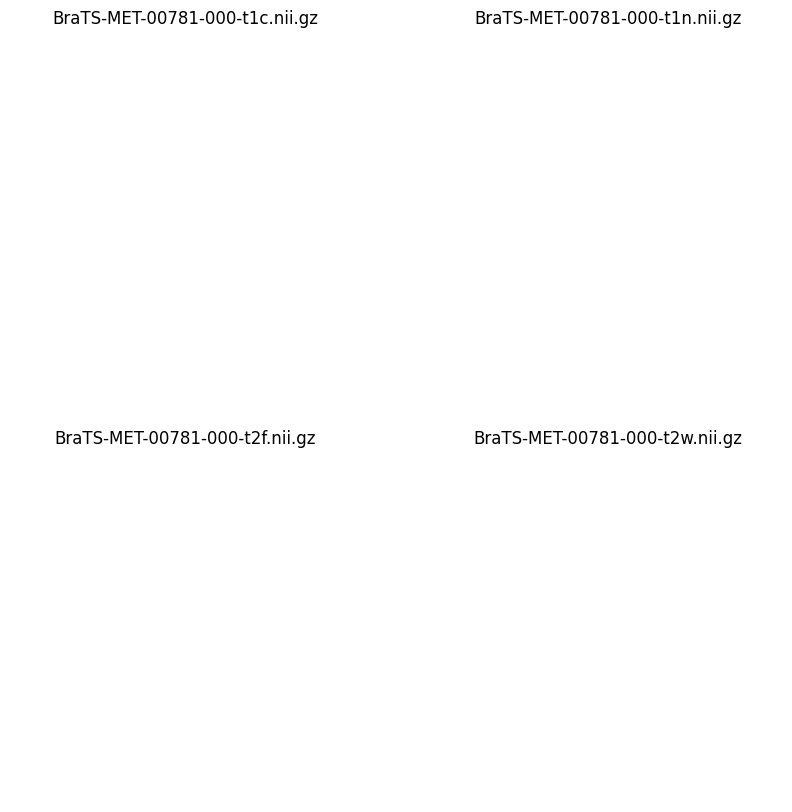

In [95]:
def animate_multiple_slices_with_overlay(image_paths, mask_paths, fps=10):
    """
    Create an animation of slices with an overlaid mask for multiple images and display it.

    Parameters:
    - image_paths: List of paths to the NIfTI images.
    - mask_paths: List of paths to the NIfTI masks.
    - orientations: List of orientations for the images.
    - fps: Frames per second for the animation.
    """
    # Load the NIfTI images and masks
    imgs = [sitk.ReadImage(image_path) for image_path in image_paths]
    masks = [sitk.ReadImage(mask_path) for mask_path in mask_paths]
    
    # Convert to numpy arrays
    img_arrays = [sitk.GetArrayFromImage(img) for img in imgs]
    mask_arrays = [sitk.GetArrayFromImage(mask) for mask in masks]

    # Get the number of slices (assuming all images have the same number of slices)
    num_slices = img_arrays[0].shape[0]

    # Create the figure and camera
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    camera = Camera(fig)

    for slice_idx in range(num_slices):
        for i, ax in enumerate(axs.flat):
            img_array = img_arrays[i]
            mask_array = mask_arrays[i]
            filename = image_paths[i].split('/')[-1]
            
            ax.imshow(img_array[slice_idx, :, :], cmap='gray')
            ax.imshow(np.ma.masked_where(mask_array[slice_idx, :, :] == 0, mask_array[slice_idx, :, :]), cmap='jet', alpha=0.5)
            ax.set_title(filename)
            ax.axis('off')
        
        camera.snap()

    animation = camera.animate(interval=1000/fps)
    return animation

id_ = train_ids[-1]
image_paths = get_image_paths_by_id(id_, TRAIN_DIR)
mask_paths = [get_mask_path_by_id(id_, TRAIN_DIR) for _ in range(4)]

animation = animate_multiple_slices_with_overlay(image_paths, mask_paths, fps=10)
html_video = animation.to_html5_video()
display(HTML(html_video))


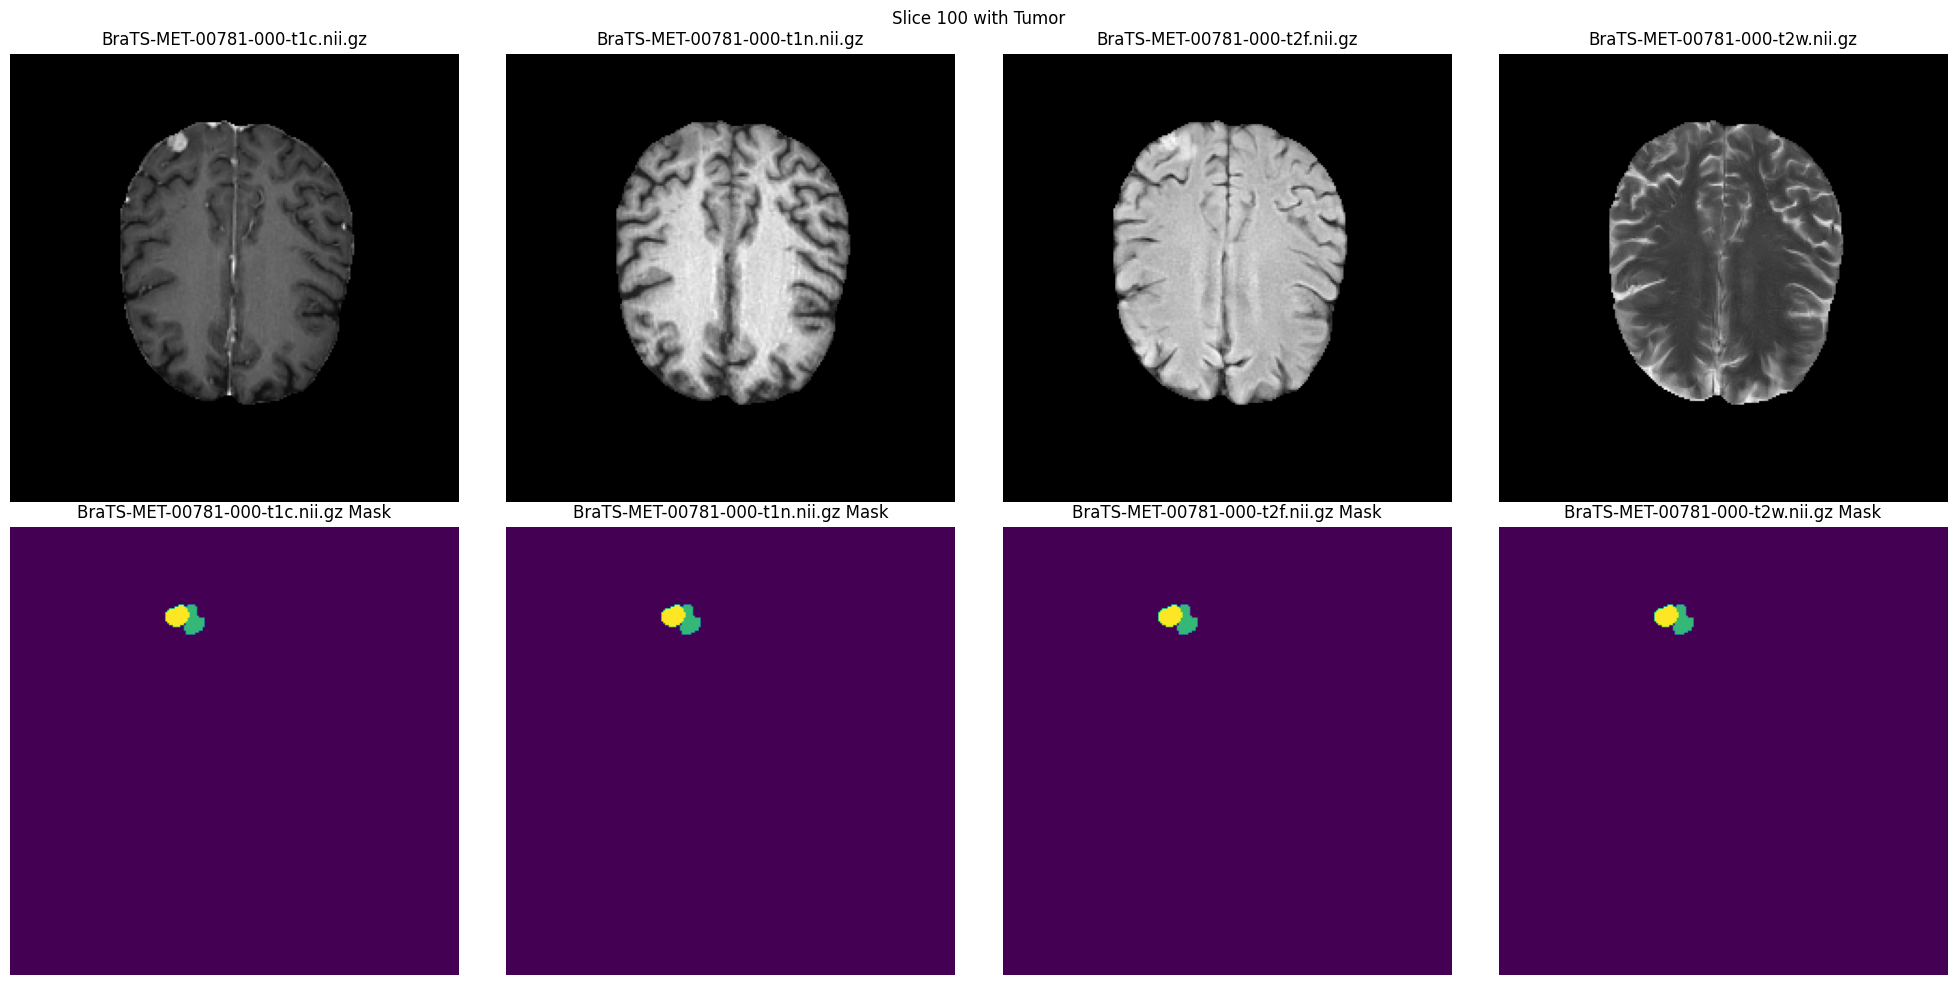

In [93]:
def find_tumor_slice(mask_array):
    """
    Find the slice index that contains the tumor.

    Parameters:
    - mask_array: Numpy array of the mask.

    Returns:
    - slice_index: Index of the slice that contains the tumor.
    """
    tumor_slices = np.any(mask_array, axis=(1, 2))
    slice_index = np.where(tumor_slices)[0]
    if len(slice_index) > 0:
        return slice_index[0]  # Return the first slice containing the tumor
    else:
        return None  # Return None if no tumor is found

def visualize_tumor_slice(image_paths, mask_path, slice_index=None):
    """
    Visualize a slice that contains the tumor for 4 modalities and plot the mask separately.

    Parameters:
    - image_paths: List of paths to the NIfTI images of different modalities.
    - mask_path: Path to the NIfTI mask.
    - slice_index: Specific slice index to visualize. If None, it will find the first slice with a tumor.
    """
    # Load the NIfTI mask
    mask = sitk.ReadImage(mask_path)
    mask_array = sitk.GetArrayFromImage(mask)

    # Determine the slice index
    if slice_index is None:
        slice_index = find_tumor_slice(mask_array)
        if slice_index is None:
            print("No tumor found in the mask.")
            return

    # Create subplots (1 row for masks and 1 row for images)
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))

    for i, image_path in enumerate(image_paths):
        # Load the NIfTI image
        img = sitk.ReadImage(image_path)
        img_array = sitk.GetArrayFromImage(img)

        # Extract the filename for the title
        filename = image_path.split('/')[-1]

        # Display the image
        axs[0, i].imshow(img_array[slice_index, :, :], cmap='gray')
        axs[0, i].set_title(f'{filename}')
        axs[0, i].axis('off')

        # Display the mask
        axs[1, i].imshow(mask_array[slice_index, :, :])
        axs[1, i].set_title(f'{filename} Mask')
        axs[1, i].axis('off')

    plt.suptitle(f'Slice {slice_index} with Tumor')
    plt.tight_layout()
    plt.show()

id_ = train_ids[-1]
image_paths = get_image_paths_by_id(id_, TRAIN_DIR)
mask_path = get_mask_path_by_id(id_, TRAIN_DIR)

visualize_tumor_slice(image_paths, mask_path, slice_index=100)


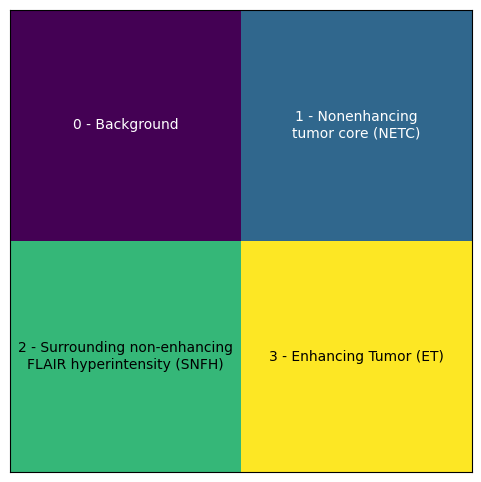

In [111]:
# Explaining color mapping

# Create an image with values 0, 1, 2, 3
image = np.array([
    [0, 1],
    [2, 3]
])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Display the image with a colormap
cax = ax.matshow(image, cmap='viridis')

# Hide the x and y ticks
ax.set_xticks([])
ax.set_yticks([])

colors = [
    ['white', 'white'],
    ['black', 'black']
]
desc = [
    ['Background', 'Nonenhancing\ntumor core (NETC)'],
    ['Surrounding non-enhancing\nFLAIR hyperintensity (SNFH)', 'Enhancing Tumor (ET)']
]

# Annotate each cell with its value
for (i, j), val in np.ndenumerate(image):
    ax.text(j, i, f'{val} - {desc[i][j]}', ha='center', va='center', color=colors[i][j])

# Display the plot
plt.show()


# 2. Analyse data for nnUNet

In [2]:
ori_train_dir = '/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData'
ori_val_dir   = '/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation'
MODALITIES    = ['t1c', 't1n', 't2f', 't2w']

def get_ori_paths(data_dir):
    ids = os.listdir(data_dir)
    id_paths = [os.path.join(data_dir, id_) for id_ in ids]
    images_fps = []
    labels_fps = []

    for id_, id_path in zip(ids, id_paths):
        fns = os.listdir(id_path)
        for fn in fns:
            fp = os.path.join(data_dir, id_, fn)
            if 'seg' in fn:
                labels_fps.append(fp)
            else:
                images_fps.append(fp)
    return images_fps, labels_fps

# Get train ids and filepaths for original data
ori_train_images_fps, ori_train_labels_fps = get_ori_paths(ori_train_dir)
print(f'{len(ori_train_images_fps)} training images, {len(ori_train_labels_fps)} training labels.')

# Get val ids and filepaths for original data
ori_val_images_fps, _ = get_ori_paths(ori_val_dir)
print(f'{len(ori_val_images_fps)} validation images.')

2608 training images, 652 training labels.
352 validation images.


In [3]:
ori_train_labels_fps[:3], ori_train_images_fps[:3], ori_val_images_fps[:3]

(['/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00559-000/BraTS-MET-00559-000-seg.nii.gz',
  '/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00001-000/BraTS-MET-00001-000-seg.nii.gz',
  '/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00002-000/BraTS-MET-00002-000-seg.nii.gz'],
 ['/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00559-000/BraTS-MET-00559-000-t1c.nii.gz',
  '/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00559-000/BraTS-MET-00559-000-t1n.nii.gz',
  '/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00559-000/BraTS-MET-00559-000-t2f.nii.gz'],
 ['/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation/BraTS-MET-00863-000/BraTS-MET-00863-000-t1c.nii.gz',
  '/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation

In [4]:
# !mkdir /media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2
# !mkdir /media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTs2
# !mkdir /media/storage/luu/nnUNet_raw/Dataset999_Metastases/labelsTr2

In [14]:
# Define paths to save nnUNet_raw
data_dir = '/media/storage/luu/nnUNet_raw/Dataset999_Metastases'
imagesTr = os.path.join(data_dir, 'imagesTr2')
labelsTr = os.path.join(data_dir, 'labelsTr2')
imagesTs = os.path.join(data_dir, 'imagesTs2')

# Copying original paths to nnUNet format paths
channel_names_dict = {
    't1c': '0000',
    't1n': '0001',
    't2f': '0002',
    't2w': '0003'
}

def to_nnunet_path(fp, phase='train'):
    fn = os.path.basename(fp)
    modality = fn.split('-')[-1][:3]
    id_ = fn.replace(f'-{modality}.nii.gz', '')

    new_fp = None
    if modality == 'seg':
        new_fn = f'{id_}.nii.gz'
        new_fp = os.path.join(labelsTr, new_fn)
    else:
        channel_name = channel_names_dict[modality]
        new_fn = f'{id_}_{channel_name}.nii.gz'
        dir_ = imagesTr if phase == 'train' else imagesTs
        new_fp = os.path.join(dir_, new_fn)

    return new_fp

In [6]:
ori_train_images_fps[1], to_nnunet_path(ori_train_images_fps[1], phase='train')

('/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00559-000/BraTS-MET-00559-000-t1n.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00559-000_0001.nii.gz')

In [7]:
ori_train_labels_fps[1], to_nnunet_path(ori_train_labels_fps[1], phase='train')

('/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-TrainingData/BraTS-MET-00001-000/BraTS-MET-00001-000-seg.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/labelsTr2/BraTS-MET-00001-000.nii.gz')

In [8]:
ori_val_images_fps[1], to_nnunet_path(ori_val_images_fps[1], phase='test')

('/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation/BraTS-MET-00863-000/BraTS-MET-00863-000-t1n.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTs2/BraTS-MET-00863-000_0001.nii.gz')

In [9]:
# Check number of images
print(f'{len(ori_train_images_fps)} training images.')
assert len(ori_train_images_fps) == 2608

print(f'{len(ori_train_labels_fps)} training labels.')
assert len(ori_train_labels_fps) == 652

print(f'{len(ori_val_images_fps)} validation images.')
assert len(ori_val_images_fps) == 352

2608 training images.
652 training labels.
352 validation images.


In [10]:
# Create paths for preprocessed images from the original data paths
pp_train_images_fps = [to_nnunet_path(fp, phase='train') for fp in ori_train_images_fps]
pp_train_labels_fps = [to_nnunet_path(fp, phase='train') for fp in ori_train_labels_fps]
pp_val_images_fps   = [to_nnunet_path(fp, phase='test') for fp in ori_val_images_fps]

print(f'{len(pp_train_images_fps)} preprocessed training images.')
print(f'{len(pp_train_labels_fps)} preprocessed training labels.')
print(f'{len(pp_val_images_fps)} preprocessed validation images.')

2608 preprocessed training images.
652 preprocessed training labels.
352 preprocessed validation images.


In [16]:
# Get nifti details
# train_nifti_details_list = [get_nifti_details_for_one_file(fp) for fp in ori_train_images_fps]
# train_nifti_details = pd.DataFrame(train_nifti_details_list)

val_nifti_details_list = [get_nifti_details_for_one_file(fp) for fp in ori_val_images_fps]
val_nifti_details = pd.DataFrame(val_nifti_details_list)
val_nifti_details.to_json('val_nifti_details.json', orient='records')

In [14]:
# Check training nifti details - Shape
train_nifti_details['shape'].value_counts()

shape
(240, 240, 155)    1312
(256, 256, 126)     184
(320, 320, 104)     148
(400, 400, 90)      132
(256, 256, 106)     120
(256, 256, 104)      80
(256, 256, 108)      76
(256, 256, 98)       64
(256, 256, 128)      52
(256, 256, 100)      48
(256, 256, 110)      44
(256, 256, 112)      32
(256, 256, 102)      32
(320, 320, 110)      24
(256, 256, 116)      24
(256, 256, 136)      16
(256, 256, 96)       16
(336, 336, 104)      16
(336, 336, 110)      12
(512, 512, 156)       8
(512, 512, 33)        8
(512, 221, 512)       8
(400, 140, 400)       8
(256, 256, 144)       8
(512, 512, 50)        8
(512, 257, 418)       4
(288, 288, 90)        4
(400, 90, 400)        4
(512, 512, 206)       4
(512, 246, 512)       4
(256, 256, 134)       4
(256, 256, 120)       4
(512, 212, 512)       4
(320, 320, 114)       4
(256, 256, 92)        4
(512, 512, 146)       4
(512, 512, 110)       4
(256, 256, 192)       4
(320, 320, 108)       4
(256, 256, 156)       4
(512, 512, 232)       4
(512, 512,

In [15]:
# Check training nifti details - Orientation
train_nifti_details['orientation'].value_counts()

orientation
(R, A, S)    2432
(L, P, S)     148
(L, A, S)      28
Name: count, dtype: int64

In [16]:
# Check training nifti details - Spacing
train_nifti_details['spacing'].value_counts()

spacing
(1.0, 1.0, 1.0)                   1312
(0.8594, 0.8594, 1.5)              500
(1.1719, 1.1719, 1.5)              252
(0.6875, 0.6875, 1.5)              184
(0.75, 0.75, 2.0)                  132
(0.8984, 0.8984, 1.5)               32
(0.71428573, 0.71428573, 1.5)       32
(0.9375, 0.9375, 1.5)               20
(0.4688, 0.4688, 3.0)               12
(0.75, 1.5, 0.75)                    8
(0.9766, 0.9766, 1.5)                8
(0.5, 1.0, 0.5)                      8
(0.5859, 0.5859, 3.0)                8
(0.4296875, 1.0, 0.4296875)          8
(0.4297, 0.4297, 5.0)                8
(1.1719, 1.1719, 1.6)                4
(1.0, 1.0, 1.5)                      4
(0.5, 0.5, 1.2)                      4
(0.5, 0.5, 1.0)                      4
(0.75, 2.0, 0.75)                    4
(0.5, 0.5, 1.1994513)                4
(0.5, 1.0000068, 0.5)                4
(1.0714285, 1.0714285, 2.0)          4
(0.4297, 0.4297, 1.5)                4
(0.4609375, 0.4609375, 1.02)         4
(1.0, 1.0, 1.0001

In [17]:
# Check validation nifti details - Shape
val_nifti_details['shape'].value_counts()

shape
(240, 240, 155)    352
Name: count, dtype: int64

In [18]:
# Check validation nifti details - Orientation
val_nifti_details['orientation'].value_counts()

orientation
(L, P, S)    292
(R, A, S)     60
Name: count, dtype: int64

In [19]:
# Check validation nifti details - Spacing
val_nifti_details['spacing'].value_counts()

spacing
(1.0, 1.0, 1.0)    352
Name: count, dtype: int64

In [22]:
val_nifti_details['affine'][0]

array([[ -1.,   0.,   0.,  -0.],
       [  0.,  -1.,   0., 239.],
       [  0.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   1.]])

In [32]:
lps_fps = val_nifti_details[val_nifti_details['orientation']==('L', 'P', 'S')]['filepath'].to_list()
lps_fns = [os.path.basename(fp) for fp in lps_fps]
lps_ids = [fn[:-11] for fn in lps_fns]
lps_ids[0]

'BraTS-MET-00863-000'

In [41]:
# Save prediction with its original orientation

pred_dir = '/media/storage/luu/nnUNet_predictions/Dataset999_Metastases/fold_all'
pred_fns = [fn for fn in os.listdir(pred_dir) if fn.startswith('BraTS')]
assert len(pred_fns) == 88
pred_fps = [os.path.join(pred_dir, fn) for fn in pred_fns]

for pred_fp in pred_fps:
    # Get original image file path
    fn = os.path.basename(pred_fp)
    id_ = fn.replace('.nii.gz', '')
    ori_fp = os.path.join(ori_val_dir, id_, f'{id_}-t1c.nii.gz')

    # Get original affine
    ori_affine = nib.load(ori_fp).affine.copy()

    # Create a new image from the pred images with original affine
    pred_img = nib.load(pred_fp).get_fdata()
    new_img = nib.Nifti1Image(pred_img, ori_affine)
    print(ori_fp, pred_fp)
    nib.save(new_img, pred_fp)

/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation/BraTS-MET-00833-000/BraTS-MET-00833-000-t1c.nii.gz /media/storage/luu/nnUNet_predictions/Dataset999_Metastases/fold_all/BraTS-MET-00833-000.nii.gz
/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation/BraTS-MET-00834-000/BraTS-MET-00834-000-t1c.nii.gz /media/storage/luu/nnUNet_predictions/Dataset999_Metastases/fold_all/BraTS-MET-00834-000.nii.gz
/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation/BraTS-MET-00835-000/BraTS-MET-00835-000-t1c.nii.gz /media/storage/luu/nnUNet_predictions/Dataset999_Metastases/fold_all/BraTS-MET-00835-000.nii.gz
/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation/BraTS-MET-00836-000/BraTS-MET-00836-000-t1c.nii.gz /media/storage/luu/nnUNet_predictions/Dataset999_Metastases/fold_all/BraTS-MET-00836-000.nii.gz
/media/storage/hdd_bair/BraTS24/MICCAI-BraTS2024-MET-Challenge-Validation/BraTS-MET-00837-000/BraTS-MET-00837-000-t1

In [33]:
import shutil
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom

def process_nifti(file_path, new_path=None):
    target_shape = (240, 240, 155)
    target_spacing = (1, 1, 1)
    target_translation = (0, -239, 0)
    
    # Load the Nifti file
    img = nib.load(file_path)
    original_spacing = img.header.get_zooms()
    original_shape = img.header.get_data_shape()

    try:
        data = img.get_fdata()
    except:
        print(f'Error when run .get_dfata() for this image using Nibabel: {file_path}')
        print('Using SimpleITK')
        img = sitk.ReadImage(file_path)
        data = sitk.GetArrayFromImage(img)
    
    # Adjust spacing if needed
    if original_spacing != target_spacing:
        scaling_factors = [os / ns for os, ns in zip(original_spacing, target_spacing)]
        # use nearest-neighbor interpolation for labels and cubic interpolation for images
        order = 0 if 'seg' in file_path else 3
        data = zoom(data, scaling_factors, order=order)

    # Adjust shape if needed
    if original_shape != target_shape:
        pad_width = [(0, max(0, target_shape[i] - data.shape[i])) for i in range(3)]
        data_padded = np.pad(data, pad_width, mode='constant', constant_values=0)
        data = data_padded[:target_shape[0], :target_shape[1], :target_shape[2]]
    
    # Create a new affine matrix for the desired orientation and spacing with dtype=float
    new_affine = np.array([
        [target_spacing[0],         0        ,        0         , target_translation[0]],
        [        0        , target_spacing[1],        0         , target_translation[1]],
        [        0        ,         0        , target_spacing[2], target_translation[2]],
        [        0        ,         0        ,        0         ,             1        ]
    ], dtype=float)
    
    # Create a new Nifti1Image with the new data and affine
    new_img = nib.Nifti1Image(data, new_affine)
    
    # Save to the new path if provided, else overwrite the original file
    if new_path:
        nib.save(new_img, new_path)
    else:
        nib.save(new_img, file_path)


def check_nifti_attributes(file_path):
    """
    Check if a Nifti image has the specified shape, orientation, spacing, and affine matrix.

    Parameters:
    - file_path (str): Path to the Nifti file.

    Returns:
    - bool: True if all criteria are met, False otherwise.
    """
    target_shape = (240, 240, 155)
    target_spacing = (1, 1, 1)
    target_orientation = ('R', 'A', 'S')
    target_affine_translation = [0, -239, 0]
    
    # Load the Nifti file
    img = nib.load(file_path)
    img_shape = img.shape
    img_affine = img.affine
    img_spacing = img.header.get_zooms()
    img_orientation = nib.orientations.aff2axcodes(img_affine)
   
    # Check shape
    if img_shape != target_shape:
        print(f"File: {file_path}")
        print(f"Shape mismatch: {img_shape} != {target_shape}")
        return False
    
    # Check spacing
    if img_spacing != target_spacing:
        print(f"File: {file_path}")
        print(f"Spacing mismatch: {img_spacing} != {target_spacing}")
        return False
    
    # Check orientation
    if img_orientation != target_orientation:
        print(f"File: {file_path}")
        print(f"Orientation mismatch: {img_orientation} != {target_orientation}")
        return False
    
    # Check affine translation
    if not np.allclose(img_affine[:3, 3], target_affine_translation):
        print(f"File: {file_path}")
        print(f"Affine translation mismatch: {img_affine[:3, 3]} != {target_affine_translation}")
        return False
    
    # If all checks pass
    return True

In [11]:
pp_train_images_fps

['/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00559-000_0000.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00559-000_0001.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00559-000_0002.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00559-000_0003.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00001-000_0000.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00001-000_0001.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00001-000_0002.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00001-000_0003.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00002-000_0000.nii.gz',
 '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/imagesTr2/BraTS-MET-00002-000_0001.nii.gz',
 '/media/storage/luu

In [12]:
# Preprocess training images
import shutil
def process_nifti(ori_path, pp_path):
    shutil.copyfile(ori_path, pp_path)
    
for ori_path, pp_path in zip(ori_train_images_fps, pp_train_images_fps):
    process_nifti(ori_path, pp_path)

# # Check preprocessed training images
# for pp_path in pp_train_images_fps:
#     check_nifti_attributes(pp_path)

KeyboardInterrupt: 

In [48]:
# Preprocess training labels
for ori_path, pp_path in zip(ori_train_labels_fps, pp_train_labels_fps):
    process_nifti(ori_path, pp_path)

# Check preprocessed training labels
for pp_path in pp_train_labels_fps:
    check_nifti_attributes(pp_path)

In [46]:
# Preprocess validation images
for ori_path, pp_path in zip(ori_val_images_fps, pp_val_images_fps):
    process_nifti(ori_path, pp_path)

# Check preprocessed validation images
for pp_path in pp_val_images_fps:
    check_nifti_attributes(pp_path)

In [ ]:
def change_shape(file_path, new_path):
    # Load the Nifti file
    img = sitk.ReadImage(ori_path)
    data = sitk.GetArrayFromImage(img)
    
    # Check original shape
    original_shape = data.shape
    if original_shape != (155, 240, 240):
        raise ValueError(f"Unexpected shape: {original_shape}. Expected (155, 240, 240).")
    
    # Permute the axes to change the shape from (155, 240, 240) to (240, 240, 155)
    data_permuted = np.transpose(data, (1, 2, 0))
    
    # Create a new Nifti1Image with the permuted data and original affine
    new_img = nib.Nifti1Image(data_permuted, img.affine)
    
    # Save the new image to the specified path
    nib.save(new_img, new_path)

(240, 240, 155)


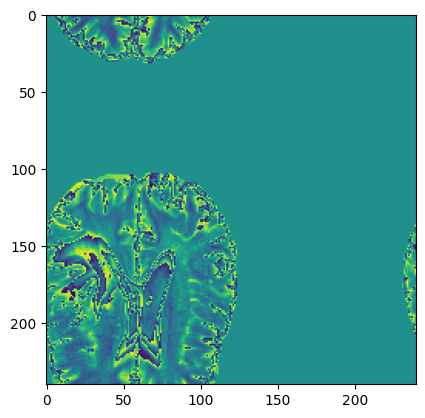

In [68]:
ori_path = os.path.join(ori_train_dir, 'BraTS-MET-00232-000', 'BraTS-MET-00232-000-t2w.nii.gz')
pp_path = '/media/storage/luu/nnUNet_raw/Dataset999_Metastases/labelsTr/BraTS-MET-00232-000.nii.gz'
img = nib.load(pp_path)
print(img.header.get_data_shape())
img = sitk.ReadImage(ori_path)
data = sitk.GetArrayFromImage(img)
plt.imshow(data[90,...])
# print(np.unique(img))

In [36]:
# Create folders for UMamba dataset
!mkdir '/home/luu/brats24/U-Mamba/data/nnUNet_raw/Dataset999_Metastases/imagesTr'
!mkdir '/home/luu/brats24/U-Mamba/data/nnUNet_raw/Dataset999_Metastases/labelsTr'
!mkdir '/home/luu/brats24/U-Mamba/data/nnUNet_raw/Dataset999_Metastases/imagesTs'

In [37]:
# Copy preprocessed images to UMamba/data
umamba_data_dir = '/home/luu/brats24/U-Mamba/data/nnUNet_raw/Dataset999_Metastases'
umamba_train_images_dir = os.path.join(umamba_data_dir, 'imagesTr')
umamba_train_labels_dir = os.path.join(umamba_data_dir, 'labelsTr')
umamba_val_images_dir   = os.path.join(umamba_data_dir, 'imagesTs')

umamba_train_images_fps = [os.path.join(umamba_train_images_dir, fn) for fn in train_images_fns]
umamba_train_labels_fps = [os.path.join(umamba_train_labels_dir, fn) for fn in train_labels_fns]
umanba_val_images_fps   = [os.path.join(umamba_val_images_dir, fn) for fn in val_images_fns]

In [ ]:
# Copy training images
for src, dst in zip(pp_train_images_fps, umamba_train_images_fps):
    shutil.copyfile(src, dst)

In [ ]:
# Copy training labels
for src, dst in zip(pp_train_labels_fps, umamba_train_labels_fps):
    shutil.copyfile(src, dst)

In [ ]:
# Copy validation images
for src, dst in zip(pp_val_images_fps, umamba_val_images_fps):
    shutil.copyfile(src, dst)